# ***Train and validate the CNN model from scratch***

# ***Startup cell:Configure TensorFlow for reproducibility and GPU memory efficiency***

In [3]:
"""
Configure TensorFlow to:
- Use all available GPUs
- Limit GPU memory (e.g., 20GB each)
- Enable MirroredStrategy for distributed training
- Ensure full reproducibility
"""

import os
import random
import numpy as np
import tensorflow as tf

# === Reproducibility Setup ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

set_seed(42)

# === GPU Memory Configuration ===
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit (in MB) per GPU
        memory_limit_mb = 20000  # 20 GB
        logical_devices = [
            tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit_mb)
            for _ in gpus
        ]

        for gpu, config in zip(gpus, logical_devices):
            tf.config.set_logical_device_configuration(gpu, [config])

        print(f"All {len(gpus)} GPU(s) configured with {memory_limit_mb}MB limit each.")

    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPUs detected — fallback to CPU.")

# === Use MirroredStrategy ===
strategy = tf.distribute.MirroredStrategy()
print(f"MirroredStrategy enabled with {strategy.num_replicas_in_sync} replica(s).")
#
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


All 2 GPU(s) configured with 20000MB limit each.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
MirroredStrategy enabled with 2 replica(s).
TensorFlow version: 2.14.0


In [12]:
# ================================
# System & Core Libraries
# ================================
import os
import random
from collections import Counter, defaultdict
from glob import glob

import cv2
import numpy as np

# ================================
# TensorFlow / Keras - Model Building & Training
# ================================
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Activation, Conv2D, Dense, Dropout, Flatten,
    GlobalAveragePooling2D, MaxPooling2D
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, load_img
)

# ================================
# Vision Transformer (ViT) Specific
# ================================
from vit_keras import utils, vit

# ================================
# Scikit-learn - Metrics & Utilities
# ================================
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve
)
from sklearn.utils import class_weight

# ================================
# Visualization & Progress
# ================================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ================================
# Jupyter/IPython Utilities
# ================================
# %matplotlib inline  # Uncomment this line when running in Jupyter Notebook
# ================================
# Global Constants
# ================================
HEIGHT = 224
WIDTH = 224


In [13]:
"""
Set up training data pipeline with augmentation using ImageDataGenerator.
"""

# === Define training directory path ===
TRAIN_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "train"))

# === Set batch size ===
BATCH_SIZE = 32

# === Define data augmentation strategy ===
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

# === Create augmented training data generator ===
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 8503 images belonging to 2 classes.


In [14]:
"""
Set up validation data pipeline using ImageDataGenerator (no augmentation).
"""

# === Define validation directory path ===
VALID_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))

# === Define validation data generator (only rescaling) ===
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# === Create validation data generator ===
validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2424 images belonging to 2 classes.


In [10]:
"""
Build and compile a CNN model from scratch, with callbacks and class weighting.
"""

# === Hyperparameters ===
EPOCHS = 10
INPUT_SHAPE = (HEIGHT, WIDTH, 3)  # Ensure HEIGHT and WIDTH are defined globally

# === Build the CNN Model ===
model = Sequential([
    Conv2D(32, (3, 3), input_shape=INPUT_SHAPE),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),

    Dense(1),
    Activation('sigmoid')
])

# === Compile the Model ===
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# === Display Model Summary ===
model.summary()

# === Callbacks ===
model_checkpoint = ModelCheckpoint(
    filepath="best_weights.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

# === Compute Class Weights from Training Data ===
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights used: {class_weights_dict}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                   

# ***Train model from scratch. As I have already trained the model and saved as "full_model.keras"  No need to run this code again***

In [11]:
"""
Train the CNN model using class weights and callbacks. 
Save the entire trained model in TensorFlow's native .keras format.
"""

# === Train the Model ===
scratch_hist = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# === Save the Full Trained Model ===
model.save("full_model.keras")


Epoch 1/10


2025-04-12 02:32:26.911683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-04-12 02:32:28.423315: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f19a062cd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-12 02:32:28.423341: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-04-12 02:32:28.423345: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2025-04-12 02:32:28.427435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-12 02:32:28.541699: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7689
Epoch 1: val_loss improved from inf to 0.35024, saving model to best_weights.keras
266/266 [==============================] - 91s 329ms/step - loss: 0.4639 - accuracy: 0.7689 - val_loss: 0.3502 - val_accuracy: 0.8049
Epoch 2/10
266/266 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8035
Epoch 2: val_loss did not improve from 0.35024
266/266 [==============================] - 90s 338ms/step - loss: 0.3665 - accuracy: 0.8035 - val_loss: 0.4154 - val_accuracy: 0.8230
Epoch 3/10
266/266 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.8218
Epoch 3: val_loss did not improve from 0.35024
266/266 [==============================] - 87s 325ms/step - loss: 0.3320 - accuracy: 0.8218 - val_loss: 0.3864 - val_accuracy: 0.8230
Epoch 4/10
266/266 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8471
Epoch 4: val_loss improved from 0.35024 to 0.309

# ***What the Output Showed (CNN From Scratch with Augmentation + Dropout)***

| Epoch | val_loss | val_accuracy | Notes                                           |
|-------|----------|--------------|-------------------------------------------------|
| 1     | 0.3502   | 80.49%       | Decent start; room for improvement              |
| 2     | 0.4154   | 82.30%       | Accuracy improves but loss increases            |
| 3     | 0.3864   | 82.30%       | Consistent accuracy; minor drop in loss         |
| 4     | 0.3096   | 82.76%       | First major improvement in both metrics         |
| 5     | 0.2354   | 88.00%       | Best epoch — lowest val_loss & high accuracy |
| 6     | 0.4596   | 85.31%       | Spike in loss; accuracy drops slightly          |
| 7     | 0.5595   | 85.77%       | Validation loss increases again                 |
| 8     | 0.4491   | 85.93%       | Still stable accuracy; early stopping triggered |

---

# ***Summary***

### Early stopping restored model weights from **Epoch 5** — the best epoch.
### The best validation accuracy was **88.00%**, with a minimum validation loss of **0.2354**.
### Loss and accuracy fluctuated slightly after epoch 5, but the model retained strong generalization.
### No major overfitting observed, although late-epoch validation loss increased slightly.
### The CNN trained from scratch **benefits well from data augmentation and dropout**, balancing simplicity with strong performance.


# === ***Plot Accuracy & Loss Curves*** ===

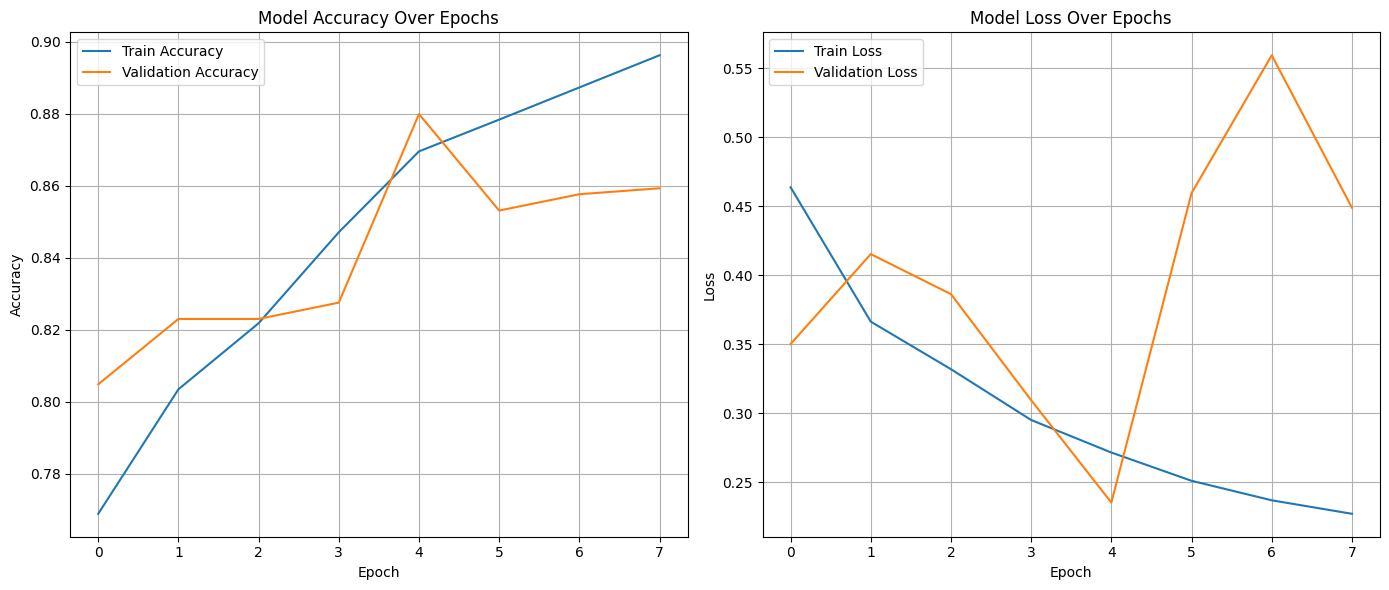

In [16]:
"""
Plot training and validation accuracy/loss curves for the CNN model.
"""

import matplotlib.pyplot as plt

# === Initialize Figure ===
plt.figure(figsize=(14, 6))

# === Accuracy Plot ===
plt.subplot(1, 2, 1)
plt.plot(scratch_hist.history['accuracy'], label='Train Accuracy')
plt.plot(scratch_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# === Loss Plot ===
plt.subplot(1, 2, 2)
plt.plot(scratch_hist.history['loss'], label='Train Loss')
plt.plot(scratch_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# === Display Layout ===
plt.tight_layout()
plt.show()


# ***Why Does the Plot Show Epoch 4 as Best, but Training Log Says Epoch 5?***
## From our Training Log:
### The lowest validation loss occurred at Epoch 5:
### Epoch 5: val_loss improved from 0.30956 to 0.23535. Hence, early stopping saved weights from Epoch 5.

## From our Plot (Image):
### Accuracy on the validation set peaked at Epoch 4:  ≈ 88%
### After that, accuracy dipped slightly even though training continued.
### However, the validation loss reached its lowest point at Epoch 5, as also shown in the plot on the right.
# ***Why the Discrepancy?***
## Because early stopping uses val_loss (not accuracy) as its monitoring metric.
### Accuracy peaked at Epoch 4 → visually looks like the “best”. But loss is a better reflection of model confidence, especially in binary classification.
### So, even if accuracy doesn't improve, a lower validation loss means the model became more confident and better calibrated. Weights for epoch '5' will be saved

## ***Model prediction on validation dataset***

In [17]:
# Load the full model
model = load_model("full_model.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                   

# ***Instead of trying thresholds by trial-error, we can plot Precision-Recall curve and ROC curve***

In [19]:
def plot_pr_and_roc(model, dataset, set_name="Validation"):
    """
    Evaluate a trained TensorFlow model on a dataset and visualize:
    - Precision-Recall curve
    - ROC curve
    - Classification report
    - Confusion matrix

    Args:
        model: Trained TensorFlow/Keras model.
        dataset: tf.data.Dataset (batched, normalized).
        set_name (str): Name of the dataset for labeling plots and reports.

    Returns:
        Tuple[float, float]: (Best threshold by F1 score, Best F1 score).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        precision_recall_curve, roc_curve, roc_auc_score,
        classification_report, confusion_matrix, ConfusionMatrixDisplay
    )

    # === Extract true labels and predicted probabilities ===
    y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)
    y_scores = model.predict(dataset).squeeze()

    # === Compute Precision-Recall and F1 scores ===
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    # === Compute ROC curve and AUC score ===
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # === Plot Precision-Recall and ROC curves ===
    plt.figure(figsize=(14, 6))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'{set_name} P-R Curve')
    plt.scatter(recall[best_idx], precision[best_idx], color='red',
                label=f'Best F1 = {best_f1:.2f} @ Threshold = {best_threshold:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='orange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Convert predictions using best F1 threshold ===
    y_pred = (y_scores >= best_threshold).astype(int)

    # === Print classification report ===
    print(f"\nClassification Report ({set_name}):")
    print(classification_report(y_true, y_pred, target_names=["Empty", "Occupied"]))

    # === Confusion matrix ===
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Empty", "Occupied"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({set_name})")
    plt.show()

    # === Summary ===
    print(f"\nBest Threshold by F1 Score: {best_threshold:.2f} (F1 = {best_f1:.2f})")
    print(f"AUC-ROC Score: {auc_score:.4f}")

    return best_threshold, best_f1


In [20]:
def load_dataset_for_prediction(directory, img_size=(224, 224), batch_size=32):
    """
    Load an image dataset for prediction using a TensorFlow/Keras model.

    Args:
        directory (str): Path to the dataset directory.
        img_size (tuple): Target size (height, width) for resizing each image.
        batch_size (int): Batch size for the data pipeline.

    Returns:
        tf.data.Dataset: A normalized dataset (no shuffling) with images and inferred labels.
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    # Normalize pixel values to [0, 1]
    return dataset.map(lambda x, y: (x / 255.0, y))


In [21]:
"""
Load the validation dataset for prediction (normalized, labeled, not shuffled).
"""

VALID_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))
valid_ds = load_dataset_for_prediction(VALID_DIR)

Found 2424 files belonging to 2 classes.


# ***Call the plot_pr_and_roc function***

76/76 [==============================] - 1s 12ms/step


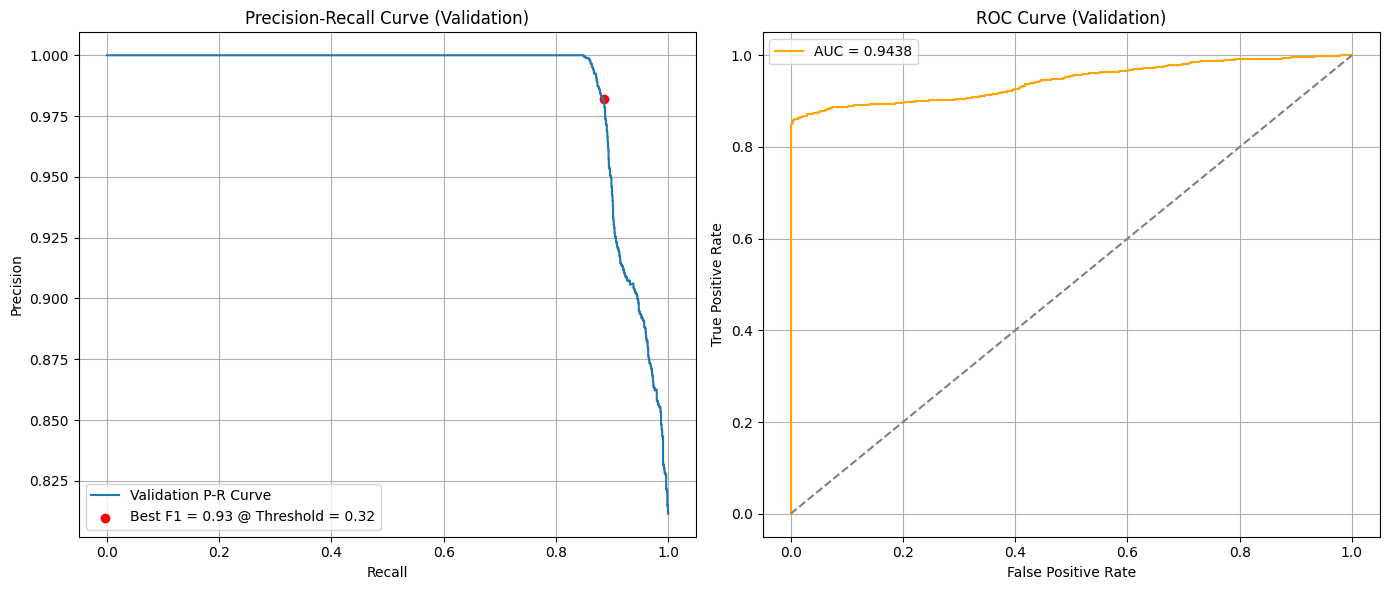


Classification Report (Validation):
              precision    recall  f1-score   support

       Empty       0.65      0.93      0.77       457
    Occupied       0.98      0.89      0.93      1967

    accuracy                           0.89      2424
   macro avg       0.82      0.91      0.85      2424
weighted avg       0.92      0.89      0.90      2424



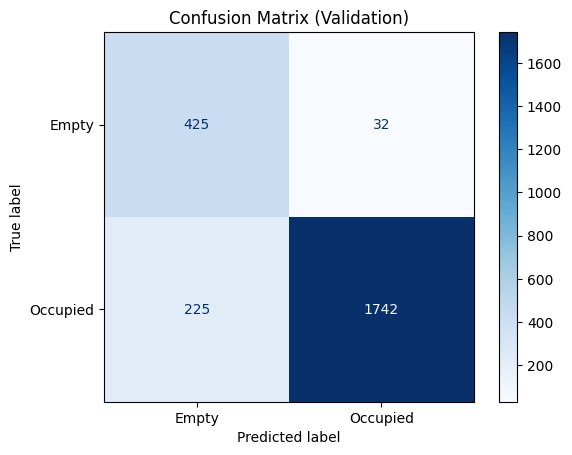


Best Threshold by F1 Score: 0.32 (F1 = 0.93)
AUC-ROC Score: 0.9438


In [22]:
# === Call the plot_pr_and_roc function on the validation set ===
best_threshold, best_f1 = plot_pr_and_roc(model, valid_ds, set_name="Validation")

Found 1216 files belonging to 2 classes.
38/38 [==============================] - 0s 12ms/step


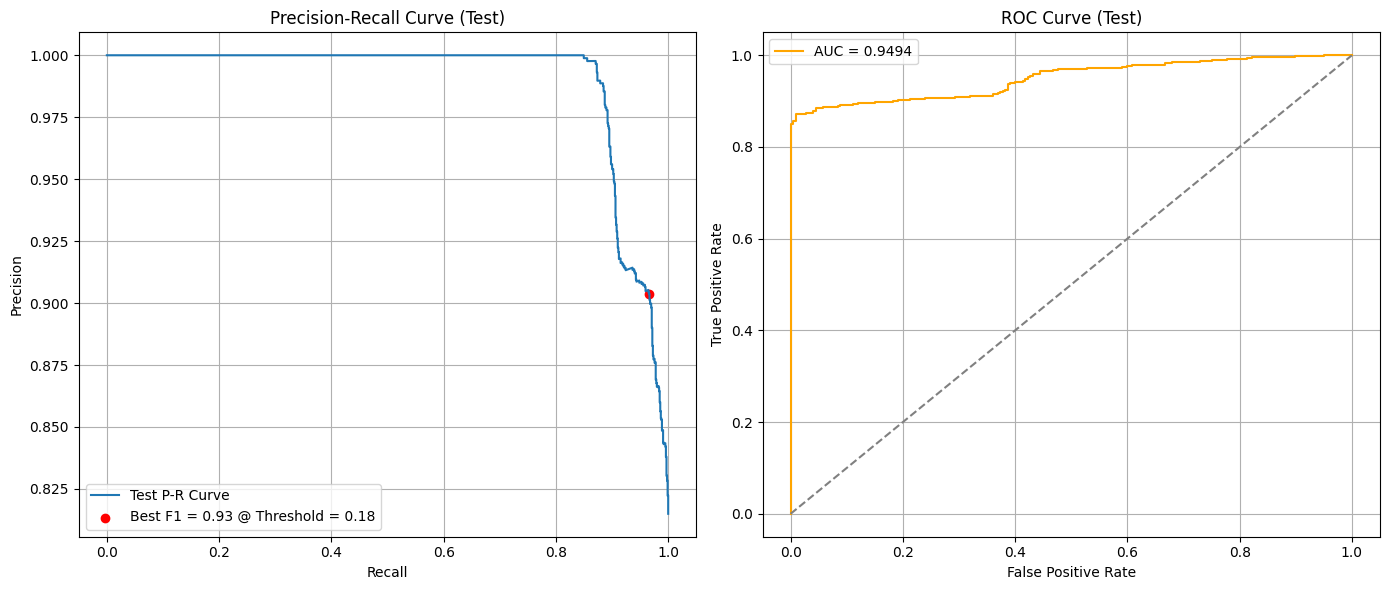


Classification Report (Test):
              precision    recall  f1-score   support

       Empty       0.79      0.55      0.65       225
    Occupied       0.90      0.97      0.93       991

    accuracy                           0.89      1216
   macro avg       0.85      0.76      0.79      1216
weighted avg       0.88      0.89      0.88      1216



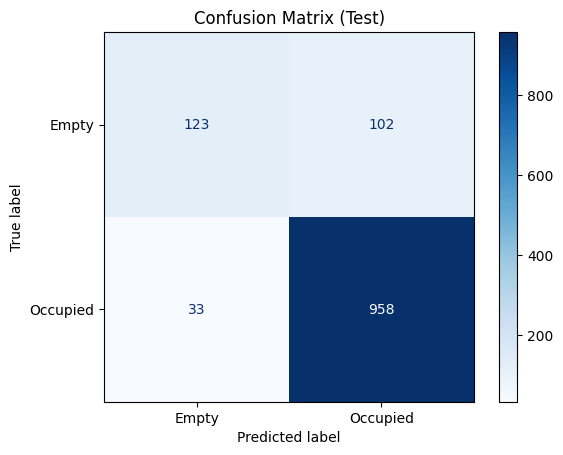


Best Threshold by F1 Score: 0.18 (F1 = 0.93)
AUC-ROC Score: 0.9494


(0.17750935, 0.9341784445424703)

In [23]:
"""
Load the validation dataset for prediction (normalized, labeled, not shuffled).
Call the plot_pr_and_roc function on the test set 
"""

TEST_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "test"))
test_ds  = load_dataset_for_prediction(TEST_DIR)
plot_pr_and_roc(model, test_ds, set_name="Test")

# ***Analysis of Model Performance Based on Precision-Recall and ROC Curves***

Our CNN model shows promising results, as seen in both the ROC and Precision-Recall curves. The best F1-score achieved is **0.93**, indicating strong performance in distinguishing between empty and occupied parking slots.

---

### **ROC Curve Analysis:**
- The ROC curves for both the validation and test sets approach the top-left corner, reflecting a **high true positive rate** and **low false positive rate**.
- The **AUC-ROC scores** are:
  - **Validation Set:** 0.9438
  - **Test Set:** 0.9494  
- These high AUC values confirm that the classifier maintains excellent class separability across both known and unseen data.

---

### **Precision, Recall, and F1-Score Analysis:**
- The **best thresholds** identified from the P-R curves are:
  - **Validation Set:** 0.32
  - **Test Set:** 0.18
- Despite the drop in threshold on the test set, the model retains its high F1-score (0.93), showing robustness even at low decision thresholds.
- This indicates the model’s confidence in its predictions even with conservative cutoffs.

---

### **Are these realistic thresholds?**
- Yes. These thresholds are realistic and even **preferable** in real-world settings where **sensitivity is critical** — for example, in safety-critical applications or systems where missing an occupied spot is costlier than a false alarm.
- A **lower threshold (0.18–0.32)** means the model casts a wider net, increasing recall. This is ideal when **avoiding false negatives** (e.g., missing an occupied slot) is more important than avoiding false positives.

---

### **Conclusion**
- The CNN model generalizes well and is **well-calibrated**.
- While the threshold varies across datasets, the **F1-score remains consistently high**, highlighting strong reliability.
- Further calibration or a unified threshold could be explored, but even in its current form, the model delivers **balanced and actionable predictions**.



# ***What is Precision in this case?***
### Precision = Of all the images the model predicted as Occupied, how many were actually Occupied?
### High precision means few false alarms. (i.e., the model doesn’t wrongly say “occupied” when it’s actually empty.)
# ***When should we try to maximize precision?***
### We want to trust the model's “occupied” prediction.
### We want to avoid blocking spots that are actually empty.

# ***What is Recall in this case?***
### Recall = Of all the actual Occupied spots, how many did the model correctly detect?
### High recall means few misses. (i.e., the model doesn’t miss cars that are actually there.)
# ***When should we try to maximize Recall?***
### We want to detect all cars, even at the cost of some false alarms.
### We are trying to track occupancy levels accurately.'
### We want to avoid saying “empty” when a car is there

# ***In Real-World Use:***
### If our app shows drivers where to park → recall is more important (so they don’t go to an already-occupied spot).
### If  our app enforces rules (e.g., penalties for occupying unauthorized spots) → precision is more important (avoid false accusations).

# Summary 
### Threshold Tradeoff in Parking Lot Classification

| Goal                             | Preferred Metric | Recommended Threshold Strategy           |
|----------------------------------|------------------|------------------------------------------|
| Avoid false “occupied” alerts    | Precision         | Use a **higher threshold** (e.g., ≥ 0.32) |
| Detect all “occupied” spots      | Recall            | Use a **lower threshold** (e.g., ≤ 0.18)  |
| Balance both precision & recall  | F1 Score          | Use **best F1 threshold** (0.32–0.18)     |

# Explanation:
### A threshold around 0.32 (validation) or even 0.18 (test) yielded the best F1-score of 0.93, indicating strong balance between precision and recall.
### The lower test threshold (0.18) emphasizes recall, reducing false negatives (i.e., missed occupied spots).
### If the use case prioritizes precision (e.g., minimizing false "occupied" alerts), a moderate-to-higher threshold is preferable.
### For general-purpose deployment, using the F1-optimal threshold (auto-selected from the P-R curve) offers the best trade-off.

# ***We define a function to predict on a randomly selected image from 'test' and'valid' set with thresholds 0.39 and 0.40***

In [25]:
def predict_random_image(set_type="valid", threshold1=0.32, threshold2=0.18):
    """
    Predict and visualize the classification of a randomly selected image from the
    'valid' or 'test' directory using two decision thresholds.

    Args:
        set_type (I am enclosing a PDFstr): Either "valid" or "test". Determines which dataset to use.
        threshold1 (float): First threshold for binary classification.
        threshold2 (float): Second threshold for comparison.

    Returns:
        None. Displays the image and prints predictions.
    """
    assert set_type in ["valid", "test"], "set_type must be either 'valid' or 'test'"

    # === Constants ===
    HEIGHT, WIDTH = 224, 224
    BASE_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", set_type))

    # === Load trained model ===
    model = load_model("full_model.keras")

    # === Gather image paths ===
    occupied_paths = glob(os.path.join(BASE_DIR, "occupied", "*.jpg"))
    empty_paths = glob(os.path.join(BASE_DIR, "empty", "*.jpg"))
    all_images = occupied_paths + empty_paths

    if not all_images:
        print(f"No images found in {BASE_DIR}")
        return

    # === Randomly select an image ===
    img_path = random.choice(all_images)
    true_label = os.path.basename(os.path.dirname(img_path)).lower()

    # === Read and preprocess the image ===
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (WIDTH, HEIGHT))
    image_input = np.expand_dims(image_resized, axis=0).astype(np.float32) / 255.0

    # === Make prediction ===
    prob = model.predict(image_input, verbose=0).squeeze()
    pred_1 = "occupied" if prob > threshold1 else "empty"
    pred_2 = "occupied" if prob > threshold2 else "empty"

    # === Display the image ===
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"True Label: {true_label}")
    plt.show()

    # === Print prediction results ===
    print(f"Set: {set_type.upper()}")
    print(f"Image Path: {img_path}")
    print(f"Predicted Probability: {prob:.4f}")
    print(f"Prediction @ Threshold {threshold1:.2f}: {pred_1}")
    print(f"Prediction @ Threshold {threshold2:.2f}: {pred_2}")


# ***Predict on a random image from validation set***

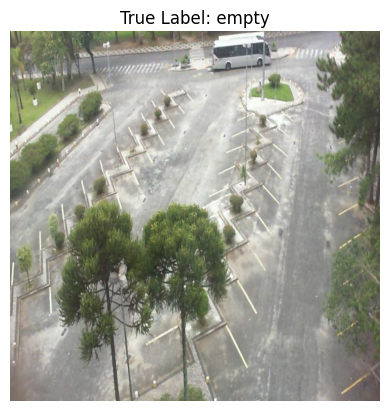

Set: VALID
Image Path: /home/ecube/sandiego/AAI_501_FINAL_TEAM_PROJECT/DATA/archive/valid/empty/2012-12-24_08_55_04_jpg.rf.90f2d34e31edbeca067ca6fc957ae220.jpg
Predicted Probability: 0.1458
Prediction @ Threshold 0.32: empty
Prediction @ Threshold 0.18: empty


In [39]:
# === Predict on a random image from the validation set ===
predict_random_image(set_type="valid")

# ***Predict on a random image from test set***

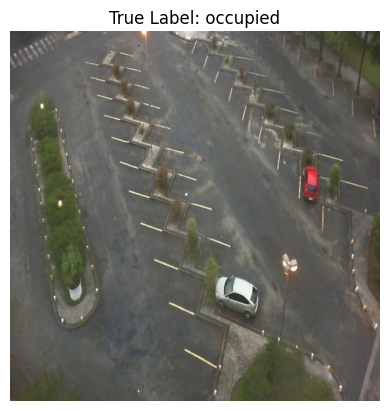

Set: TEST
Image Path: /home/ecube/sandiego/AAI_501_FINAL_TEAM_PROJECT/DATA/archive/test/occupied/2013-03-19_07_00_01_jpg.rf.e53e5e1e3a2d8f6a890c895758de87cd.jpg
Predicted Probability: 0.9126
Prediction @ Threshold 0.32: occupied
Prediction @ Threshold 0.18: occupied


In [28]:
# === Predict on a random image from the test set ===
predict_random_image(set_type="test")

# ***Though This model trained from scratch looks good. We will try to make a better model using vision transformer library. So keeping this as base model***